# Recurrent Neural Network
***
**Name**: Nicholas Renninger
***

## Goal
The goal of this assignment is to use TensorFlow to build some recurrent neural nets (RNNs) and to understand their limitations through experimentation.


## The Task
You will implement a recurrent neural net to learn the parity operator. The net will have a single input unit and a single output unit, and a fully-connected layer of H hidden units. The inputs and target outputs are binary. When an input sequence is presented, the output state at the end of the sequence should be a parity bit: output should be 1 if the input has an odd number of '1' values. For example, the sequence 1-0-0-1-0-1 should yield output 1 and the sequence 0-0-0-0-1-1 should yield output 0. Note that a target is given only at the end of each sequence. (Parity is easy to learn if there is a target at each step that indicates parity given the sequence so far.)

Parity is a hard problem for neural nets to learn because very similar inputs produce different outputs, and very dissimilar inputs can produce the same output.

The aspects of the task we will manipulate are:  H, the number of hidden units, N, the length of the input strings, and the activation function for the hidden units, either tanh or LSTM-style neurons. The output neuron should have a logistic activation function.

Tip: get started early.  Depending on your system, these nets can take several minutes to train.  Exploring hyperparameters (such as training rate) will be critical for success.


### Some Help
Below are some helper codes to:
- generate input strings and their parity.
- provide a callback to trigger early stopping during training
- plotting

In [0]:
# %load_ext tensorboard
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
import logging

# don't want to try to use TPU when not in colab
from contextlib import suppress
try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False
    from contextlib import nullcontext

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

TensorFlow 2.x selected.


Resolve TPU Address

In [0]:
WANT_TO_USE_TPU = False
USE_TPU = IN_COLAB and WANT_TO_USE_TPU
if USE_TPU:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
        tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    logger = tf.get_logger()
    logger.setLevel(logging.WARN)

In [0]:
def gen_binary_sequences(num, length):
    '''
    Generate :num: sequences of length :length:.
    '''
    return np.float32(np.random.randint(0, 2, size=(num, length, 1), dtype=np.int32))

def calc_parity(seqs):
    '''
    Calculate sequence parity (1 if odd number of 1s, 0 if even number of 1s)
    '''
    return np.float32(seqs.sum(axis=1) % 2)

def plot_accuracies(accuracies, Ns, Hs, plot_title):
    '''
    Make a graph of mean % correct (and standard error) on the test set for the
    different values of H and N.

    Input: ndarray of |Hs|x|Ns|x(reps)
         actual values of Ns and Hs
    '''
    
    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]
    
    lenH,lenN,lenreps = accuracies.shape
    assert(lenH == len(Hs))
    assert(lenN == len(Ns))
    
    accuracies_mean = accuracies.mean(axis=2)
    accuracies_std = accuracies.std(axis=2)
    accuracies_stderr = accuracies_std/np.sqrt(lenreps)

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axhline(0.5,linestyle="--",color="gray") # chance baseline
    centers = np.arange(lenN)

    for Hindex, H in enumerate(Hs):
        ax.bar(centers + 0.8/lenH*(Hindex-(lenH-1)/2),
               accuracies_mean[Hindex], 0.8/lenH,
               yerr=accuracies_stderr[Hindex],
               alpha=0.5, label=f"{H} hidden units")

    ax.set_xlabel("sequence length")
    plt.xticks(centers,Ns)
    ax.set_ylabel("test accuracy")
    plt.legend(loc="lower left")
    plt.title(plot_title)

class create_accuracy_callback(tf.keras.callbacks.Callback):
    '''
    Callback function to stop training at a minimum accuracy
    '''
    def on_epoch_end(self, epoch, logs={}, min_accuracy=0.98):

        if(logs['accuracy'] >= min_accuracy and
           logs['val_accuracy'] >= min_accuracy):
            self.model.stop_training = True

## Part 1

Experiments with vanilla RNNs $\textrm{tanh}$ activations.

### Part 1.a
Fill in the code to create a net given H and N using the tanh activation function for the hidden units.  Keras has a number of RNN helper functions, although you can also write your own custom layers.

Remember that the net should only take one bit of input at a time from the input sequence, and output one logistic value (between 0 and 1) only after the input sequence is complete.

In [0]:
def build_tanh_model(N, H):
    '''
    Builder for an RNN model with tanh hidden activations.
    Model inputs are binary sequences of length :N:.

    At each sequence position, the input and prior state should be fully
    connected to :H: hidden units with tanh activation.

    The output of the last state of the RNN should be fully connected to a 
    single unit with logistic activation, to perform the final 
    classification of the sequence.
    '''

    # dropout is bad lol
    model = models.Sequential([
        layers.Bidirectional(layers.SimpleRNN(units=H,
                                              activation='tanh',
                                              dropout=0.0,
                                              recurrent_dropout=0.0)),
        layers.Dense(1, activation='sigmoid')
        ], name='tanh')
    return model

### Part 1.b
Then fill in the code to train several such nets.  Each repetition should randomize the initial weights and generate a random training set of 10000 examples of length N as well as a random test set of 10000 examples of length N.  Save 10% of the training as validation, and use at least the provided check_accuracy callback as an early stopping condition.

Train nets for H ∈ {5, 25} and for N ∈ {5, 10, 15, 20}.  For each combination of H and N, run 10 replications of your simulation.  You will also need to try to find helpful learning rates; don't be surprised if your training is prone to cycles of stagnation for hundreds of epochs before quickly learning.

In [0]:
def train_model(model, train_dataset, epochs, val_dataset,
                early_termination_callback, alpha, momentum):
    '''
    Trains the :model:.
    
    return:
    
    test_accuracy (float): a list the length of epochs that contains the
                           model's val_acc metric during each epoch of training
    '''

    # start by compiling the model; accuracy should be a tracked metric

    if model.name == 'LSTM':
        opt = optimizers.RMSprop(learning_rate=alpha, momentum=momentum)
    elif model.name == 'tanh':
        opt = optimizers.Adamax(lr=alpha)
    else:
        raise ValueError(f'model.name={model.name} must be "LSTM" or "tanh"')

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    # train model
    history = model.fit(train_dataset,
                        epochs=epochs,
                        verbose=0,
                        validation_data=val_dataset,
                        callbacks=[early_termination_callback])

    return model

Now, we need to define a function to take all of our model / training parameter exploration ranges and:

* perform multiple experiments per parameter combination
* train the desired RNN model using different combination parameters for each experiment 
* collect and return the test set accuracy the model using each set of parameter pairs for each experiment

In [0]:
def study_rnn_performance(model_builder, Hs, Ns, early_termination_callback,
                          alphas, momentums,
                          REPS=10, SAMPLES=10000, BATCH_SIZE=1000,
                          MAX_EPOCHS=2000):

    test_accs = np.zeros([len(Hs), len(Ns), REPS])

    for ((Nindex, N), alpha, momentum) in zip(enumerate(Ns), alphas, momentums):
        print('')
        for rep in range(REPS):

            # (data is reusable across changes to the number of hidden units)
            # generate a random training set of SAMPLES examples of length N
            x = gen_binary_sequences(num=(2 * SAMPLES), length=N)
            y = calc_parity(x)

            (x_train, x_test,
             y_train, y_test) = train_test_split(x, y, test_size=SAMPLES)

            (x_train, x_val,
             y_train, y_val) = train_test_split(x_train, y_train,
                                                test_size=0.1)

            # convert to tf datasets for speed
            train_dataset = tf.data.Dataset.from_tensor_slices((x_train,
                                                                y_train))
            test_dataset = tf.data.Dataset.from_tensor_slices((x_test,
                                                               y_test))
            val_dataset = tf.data.Dataset.from_tensor_slices((x_val,
                                                              y_val))

            # use tf to apply the batch size operations
            train_dataset = train_dataset.batch(BATCH_SIZE)
            test_dataset = test_dataset.batch(BATCH_SIZE)
            val_dataset = val_dataset.batch(BATCH_SIZE)

            # cache the whole, small datasets in wham
            train_dataset = train_dataset.cache()
            test_dataset = test_dataset.cache()
            val_dataset = val_dataset.cache()

            for Hindex, H in enumerate(Hs):
                print(f"starting N={N}, H={H}, rep {rep + 1} / {REPS}")

                if USE_TPU:
                    strategy = tf.distribute.experimental.TPUStrategy(resolver)
                else:
                    strategy = None

                with (strategy.scope() if USE_TPU else suppress()):

                    model = model_builder(N, H)

                    model = train_model(model, train_dataset,
                        epochs=MAX_EPOCHS,
                        val_dataset=val_dataset,
                        early_termination_callback=early_termination_callback,
                        alpha=alpha, momentum=momentum)
                    
                    results = model.evaluate(test_dataset)
                    test_acc = results[1]
                    
                    # save for plotting later
                    test_accs[Hindex, Nindex, rep] = test_acc
                    
                    print(f'test accuracy: {test_acc}')   
                
    return test_accs

For this part, we will explore a range of sequence lengths and number of hidden units in an using tanh hidden layer activations RNN:

In [0]:
Hs = [5, 25]
Ns = [5, 10, 20, 40] # 1e-1, 5e-3, 5e-3, who Cares
check_accuracy = create_accuracy_callback()

# Adamax
alphas = [1e-1, 1e-2, 3e-3, 1e-1]
momentums = [None, None, None, None]

test_accs = study_rnn_performance(build_tanh_model, Hs, Ns,
                                  alphas=alphas, momentums=momentums,
                                  early_termination_callback=check_accuracy)


starting N=5, H=5, rep 1 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 1 / 10
10/10 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=5, rep 2 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 2 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=5, rep 3 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0846 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 3 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=5, rep 4 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 4 / 10
10/10 [======

**Part 1.c**<br>
Make the graph of mean % correct (and standard error) on the test set for the different values of H and N.

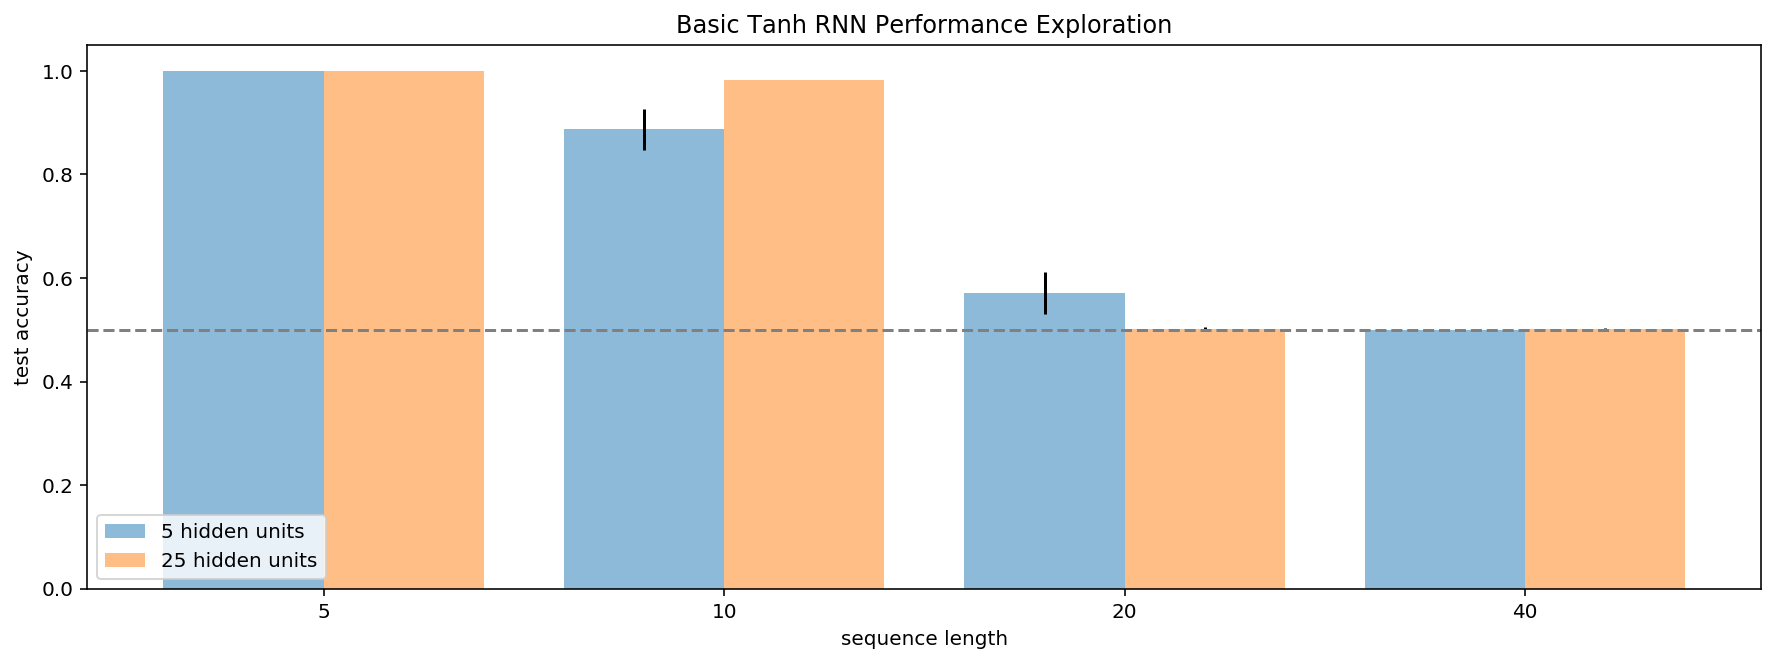

In [0]:
plot_accuracies(test_accs, Ns, Hs,
                plot_title='Basic Tanh RNN Performance Exploration')

## Part 2
Repeat the experiments of Part 1, but use LSTM neurons instead of tanh neurons in the recurrent layer.  Comment on your experiences.

#### Model Creation
To do this part, all we will need to do is write a new model builder using an LSTM recurrent layer:

In [0]:
def build_LSTM_model(N, H):
    '''
    Builder for an RNN model with LSTM hidden neurons.
    Model inputs are binary sequences of length :N:.

    At each sequence position, the input and prior state should be fully
    connected to :H: LSTM hidden units neurons.

    The output of the last state of the RNN should be fully connected to a 
    single unit with logistic activation, to perform the final 
    classification of the sequence.
    '''

    # dropout is bad lol
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(units=H,
                                         dropout=0.0)),
        layers.Dense(1, activation='sigmoid')
        ], name="LSTM")

    return model

#### Model Analysis

Now, we will re-use the training and analysis functions from Part 1 to compare the LSTM performance:

In [0]:
Hs = [5, 25]
Ns = [5, 10, 20, 40] # 9e-3, 9e-3, 4e-3, who Cares
check_accuracy = create_accuracy_callback()

# RMSProp
alphas = [9e-3, 9e-3, 4e-3, 1e-3]
momentums = [1e-4, 1e-4, 2e-4, 2e-4]

test_accs = study_rnn_performance(build_LSTM_model, Hs, Ns,
                                  alphas=alphas, momentums=momentums,
                                  early_termination_callback=check_accuracy)


starting N=5, H=5, rep 1 / 10
10/10 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 1 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.1162 - accuracy: 0.9658
test accuracy: 0.9657999873161316
starting N=5, H=5, rep 2 / 10
10/10 [==============================] - 0s 5ms/step - loss: 0.0532 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 2 / 10
10/10 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=5, rep 3 / 10
10/10 [==============================] - 0s 5ms/step - loss: 0.1554 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 3 / 10
10/10 [==============================] - 0s 5ms/step - loss: 0.1092 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=5, rep 4 / 10
10/10 [==============================] - 0s 5ms/step - loss: 0.1524 - accuracy: 1.0000
test accuracy: 1.0
starting N=5, H=25, rep 4 / 1

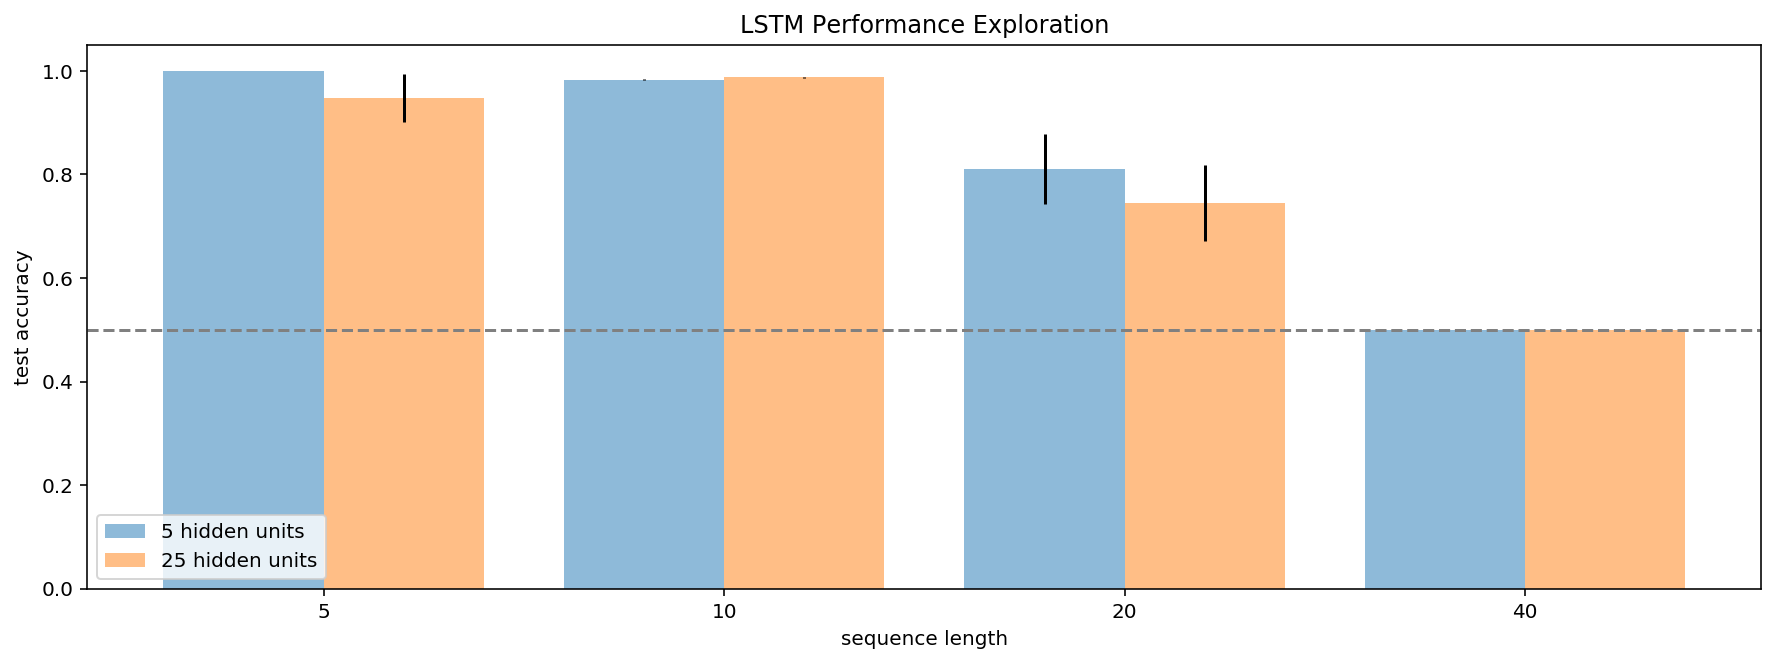

In [0]:
plot_accuracies(test_accs, Ns, Hs,
                plot_title='LSTM Performance Exploration')

#### Discussion and Conclusion

My RNN / LSTM are just basic *bi-directional* RNN / LSTM recurrent layers (bi-directional really helps to improve back-propagation) using dense logistic (`sigmoid`) outputs with `binary_crossentropy` loss.

While tempting to use **dropout / regularization** (especially with `H = 25`), I don't think it actually makes sense in this case, since our data is perfectly generated, so doing any sort of regularization is likely to just result in under-fitting.

I found that **regularization of any meaningful sort would always result in under-fitting**, despite its theoretical soundness (and necessity). I think the perfect examples of the parity function are just too difficult to fit with the very simple models we experiment with in this homework.

#### Optimizer Selection and Tuning
What made a big difference was the **choice of optimizer**. I tried all of the optimizers available through the `tensorflow.keras.optimizers` API. 

* Because of our sequential data, the `Adamax` was the most generalizable optimizer for the **vanilla RNN** (although not always the speediest for smaller `N`). 

* For the **LSTM model**, `Adamax` also worked well, but I actually found better performance using CUDA-enabled LSTM recurrent layers along with the more standard `RMSProp` optimizer. 

It is very important that you systematically, empirically **tune the basic optimizer parameters for each `N` value** if you want to have quickly training, generalizable models with `N > 5`. 


#### Overall Perfomance and Comparison
The **overall performance** of the LSTM-based model was vastly superior to that of the vanilla-RNN-based model:

* With extensive experimentation, I could get the vanilla RNN with `H = 5` to achieve test accuracies above 75% with `N = 20`, but the accuracies had *high variance* and this required extreme *optimizer optimization* (haha).

* With only minor experimentation with the standard `RMSProp` optimizer, I was able to find learning rates and momentums that made the **LSTM model vastly outperform** the  vanilla RNN on `N=20`.

Both LSTM and vanilla RNN struggled with the very difficult task of predicting parity for sequences of `N = 40`, with no tested model / optimization  combination performing better than simply binary "guessing" classification test accuracy.